In [1]:
!pip install torch matplotlib boto3

import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import boto3, os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.3 MB/s eta 0:00:00


In [2]:
# ----- PINN model -----
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

In [3]:
# ----- Training setup -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
alpha = 0.1  # thermal diffusivity

In [4]:
# ----- Physics-Informed Loss -----
def pinn_loss(n_samples=1000):
    x = torch.rand((n_samples,1), device=device)
    t = torch.rand((n_samples,1), device=device)
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)
    u_t = autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # heat equation residual: u_t - alpha*u_xx = 0
    f = u_t - alpha * u_xx
    return torch.mean(f**2)

In [6]:
# ----- Training loop -----
for epoch in range(250):
    loss = pinn_loss()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 0.000000
Epoch 50: Loss = 0.000005
Epoch 100: Loss = 0.000000
Epoch 150: Loss = 0.000012
Epoch 200: Loss = 0.000000


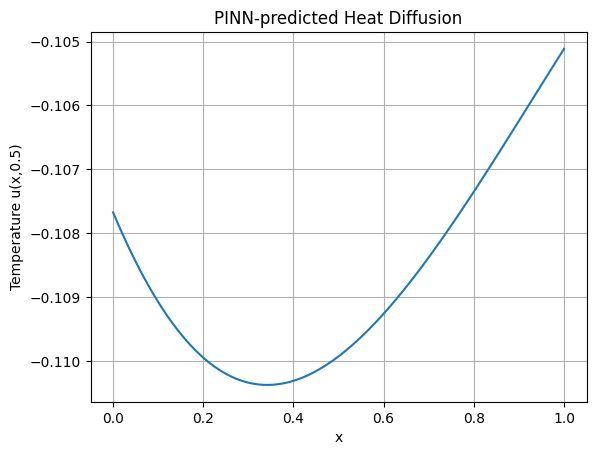

In [7]:
# ----- Plot learned temperature profile -----
x = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
t = torch.ones_like(x)*0.5  # snapshot at mid time
u_pred = model(x, t).detach().cpu().numpy()

plt.plot(x.cpu().numpy(), u_pred)
plt.xlabel("x")
plt.ylabel("Temperature u(x,0.5)")
plt.title("PINN-predicted Heat Diffusion")
plt.grid()
plt.savefig("pinn_heat.png")
plt.show()